$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib notebook
# import libraries
import os
import numpy as np
import os.path as path
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt

In [2]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [3]:
# if recieve error for pytables library you should uncomment the line below and run the cell
import sys

# !conda install --yes --prefix {sys.prefix} pytables

In [4]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_tof = wd.dataset_tdc_selection()
display(tdc, pulse_mode, max_tof)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='5000', description='Max tof:', placeholder='Maximum possible tof')

$\text{Path to the dataset}$

In [5]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

max_tof_ini = float(max_tof.value) # ns

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/load_crop/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
        
# dataset name
filename = dataset_path
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dld_group_storage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc_model, pulse_mode=pulse_mode_ini, max_tof=max_tof_ini)

print('Total number of Ions:', len(dld_group_storage))

Filename>> C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/OLO_AL_6_data.h5
{'cropped_dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 2000106


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

In [6]:
dld_group_storage

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm)
0,500.000000,500.000000,11367.0,3746.360808,-25.310204,25.373878
1,501.897491,501.897491,29203.0,2564.370792,14.231020,19.579592
2,503.034485,503.034485,44265.0,2048.793210,25.819592,-19.261224
3,503.034485,503.034485,47099.0,3220.811694,17.414694,20.916735
4,503.034485,503.034485,47416.0,1394.704602,0.509388,28.780408
...,...,...,...,...,...,...
2000101,5710.397949,5710.397949,57835.0,611.363268,-11.493061,-17.255510
2000102,5710.397949,5710.397949,57889.0,602.125542,3.756735,-14.644898
2000103,5710.397949,5710.397949,58516.0,604.745298,2.260408,-17.733061
2000104,5710.397949,5710.397949,59519.0,613.502964,-22.540408,-0.923265


<IPython.core.display.Javascript object>


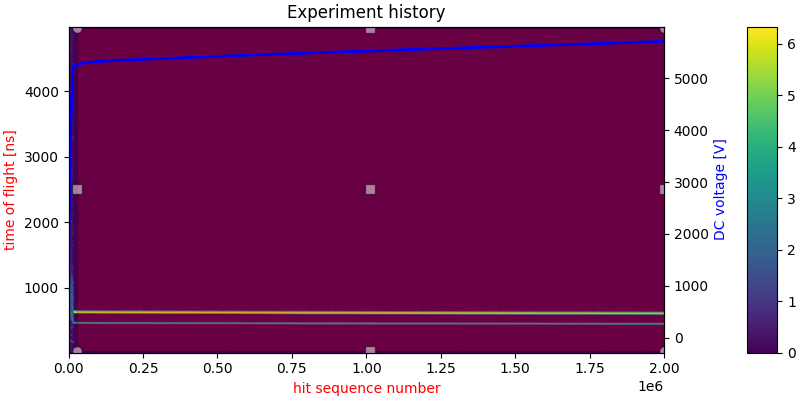

In [9]:
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, save_name = variables.result_path + '//ex_hist_' + dataset_name)



$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [10]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_group_storage)

Min Idx: 28208.7793093262 Max Idx: 1999706.418807263


<IPython.core.display.Javascript object>


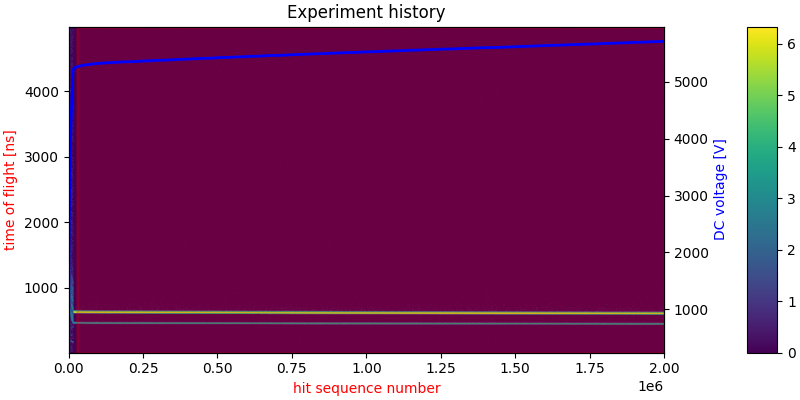

In [11]:
# Plot and selected experiment history
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

<IPython.core.display.Javascript object>


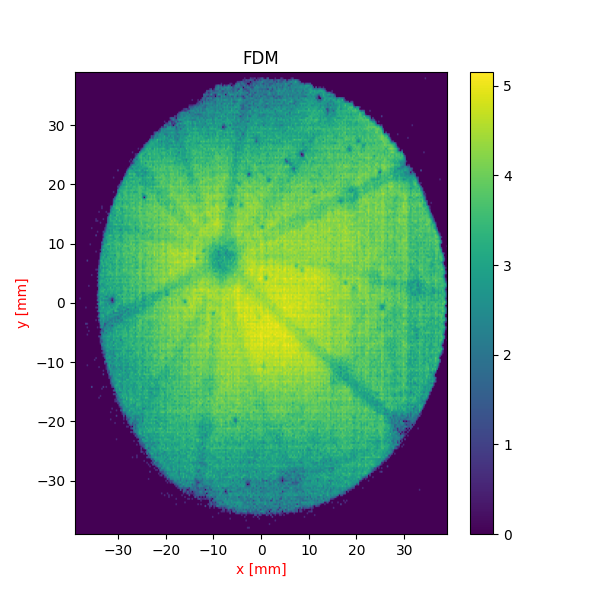

11-29-2022 11:29:41 | INFO | Plot saved by the name C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/OLO_AL_6_data/load_crop///FDM_OLO_AL_6_data
11-29-2022 11:29:41 | INFO | Plot saved by the name C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/OLO_AL_6_data/load_crop///FDM_OLO_AL_6_data


In [12]:
# Plot and select the FDM
data_loadcrop.plot_crop_FDM(data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

<IPython.core.display.Javascript object>


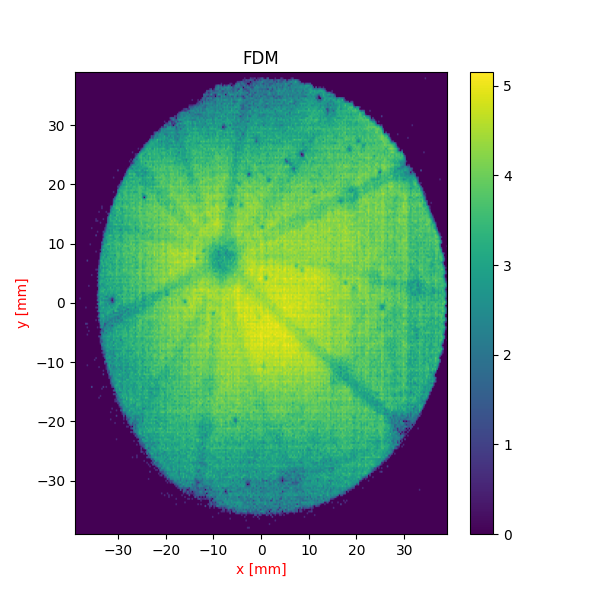

x: 0 y: 0 roi: 0
11-29-2022 11:33:13 | INFO | Plot saved by the name C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/OLO_AL_6_data/load_crop///FDM_c_OLO_AL_6_data
11-29-2022 11:33:13 | INFO | Plot saved by the name C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/OLO_AL_6_data/load_crop///FDM_c_OLO_AL_6_data


In [19]:
# plot selected area in FDM
data_loadcrop.plot_crop_FDM(data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name, circle=True)

$\text {The final selected data after processing is shown below.}$

In [ ]:
# Crop and plot the dataset
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_crop_FDM(data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name, only_plot=True)

In [ ]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM['start_counter'].to_numpy()

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped dataset
data_crop_FDM['pulse_pi'] = pulse_pi
data_crop_FDM['ion_pp)'] = ion_pp


$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [ ]:
# save the cropped data

print('tof Crop Loss {:.2f} %'.format(((1 - len(data_crop_FDM) / len(dld_group_storage)) * 100)))

In [ ]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data_crop_FDM['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data_crop_FDM['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data_crop_FDM['pulse (deg)'].to_numpy()
dld_t = data_crop_FDM['t (ns)'].to_numpy()
dld_x = data_crop_FDM['x (mm)'].to_numpy()
dld_y = data_crop_FDM['y (mm)'].to_numpy()
from pyccapt.calibration.mc import mc_tools
mc_seb_ini = mc_tools.tof2mc(dld_t, 51, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, 110, mode='voltage_pulse')
data_crop_FDM.insert(4, 'mc (Da)', mc_seb_ini)

In [ ]:
data_crop_FDM

In [ ]:
# save the dataset to hdf5 file
hierarchyName = 'df'
data_tools.store_df_to_hdf(savename, data_crop_FDM, hierarchyName)

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_crop_FDM, variables.result_path + dataset_name + '.csv')